In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('/storage/skyline12/data')

In [3]:
!mkdir -p temp

In [4]:
import tensorflow as tf


def split_outputs(x, y, z):
    return (x, (y, z))


FOLDS = 2
train_ds = skyline12.as_tf_dataset(FOLDS, subset='train').map(split_outputs)
validation_ds = skyline12.as_tf_dataset(FOLDS, subset='validation').map(split_outputs)

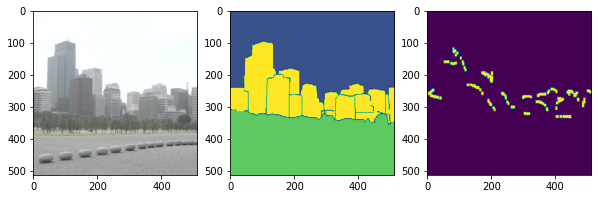

In [5]:
img, [annot, seed] = next(iter(train_ds))
Skyline12.show_sample(img, [annot, seed], from_tensors=True)

In [6]:
import wandb
wandb.init(project="skyline12-evidence", tags=[], config={
    'max_epochs': 5,
    'lambda': 1.5,
    'q_activation': 'tanh',
    'q_loss': 'binary_crossentropy',
    'q_optimizer': 'adam',
    'q_learning_rate': 0.00001,
    'dataset': f'skyline12-folds{FOLDS}-evidence-as-img'
}, notes='test run with tanh and small lr')

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Error: Can't connect to network to query entity from API key

In [7]:
from models.unet import create_unet
from tensorflow.keras.layers import Input, Conv2D
from metrics import CategoricalMeanIou

unet = create_unet()
unet_weights = wandb.restore('model-best.h5', run_path='vassilis_krikonis/unet-baseline/3p543by5')
unet.load_weights(unet_weights.name)

img = Input(shape=(512, 512, 3), name='X')
intermid_unet = tf.keras.Model(unet.input, [unet.output, unet.layers[-2].output], name='Unet')
[x, v] = intermid_unet(img)
v = Conv2D(
    2,
    (1, 1),
    padding='same',
    kernel_initializer=wandb.config.get('q_kernel_initializer'),
    activation=wandb.config.get('q_activation'),
    name='Q'
)(v)
evid_model = tf.keras.Model(inputs=img, outputs=[x, v])
if wandb.config.get('q_optimizer') == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=wandb.config.get('q_learning_rate'))
elif wandb.config.get('q_optimizer') == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=wandb.config.get('q_learning_rate'), momentum=0.99)
else:
    optimizer = wandb.config.get('q_optimizer')
evid_model.compile(
    optimizer=optimizer,
    loss=['categorical_crossentropy', wandb.config.get('q_loss')],
    loss_weights=[1.0, wandb.config.get('lambda')],
    metrics=[[CategoricalMeanIou(num_classes=5), 'accuracy'], ['accuracy']],
    run_eagerly=False
)

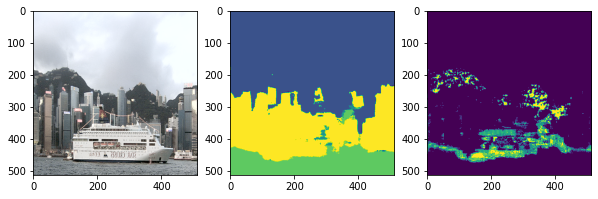

In [8]:
x, _ = next(iter(validation_ds.batch(1)))
[y_preds, z_preds] = evid_model(x)
Skyline12.show_sample(x[0], [y_preds[0], z_preds[0]], from_tensors=True)

In [9]:
import wandb
from callbacks import MyWandbCallback

early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
data_to_log = next(iter(validation_ds.batch(10)))

AUTOTUNE = tf.data.experimental.AUTOTUNE
evid_model.fit(
    train_ds.batch(3).cache(f'temp/train_{FOLDS}_xyz_img').prefetch(AUTOTUNE),
    epochs=wandb.config.get('max_epochs'),
    validation_data=validation_ds.batch(3).cache(f'temp/val_{FOLDS}_xyz_img').prefetch(AUTOTUNE),
    callbacks=[
        early_stopper,
        MyWandbCallback(
            val_data=data_to_log,
            save_model=True,
            save_weights_only=True,
            input_type='image',
            output_type='segmentation_mask')
    ]
)

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
54/54 [==============================] - 33s 618ms/step - loss: 1.5715 - Unet_loss: 0.2285 - Q_loss: 0.8953 - Unet_categorical_mean_iou: 0.6553 - Unet_accuracy: 0.9484 - Q_accuracy: 0.9285 - val_loss: 1.5377 - val_Unet_loss: 0.3785 - val_Q_loss: 0.7727 - val_Unet_categorical_mean_iou: 0.5303 - val_Unet_accuracy: 0.9272 - val_Q_accuracy: 0.9305
Epoch 2/5
54/54 [==============================] - 30s 560ms/step - loss: 1.3967 - Unet_loss: 0.2205 - Q_loss: 0.7841 - Unet_categorical_mean_iou: 0.6543 - Unet_accuracy: 0.9488 - Q_accuracy: 0.9338 - val_loss: 1.4408 - val_Unet_loss: 0.3783 - val_Q_loss: 0.7083 - val_Unet_categorical_mean_iou: 0.5295 - val_Unet_accuracy: 0.9273 - val_Q_accuracy: 0.9346
Epoch 3/5
54/54 [==============================] - 30s 560ms/step - loss: 1.3343 - Unet_loss: 0.2191 - Q_loss: 0.7435 - Unet_categorical_mean_iou: 0.6527 - Unet_accuracy: 0.9487 - Q_accuracy: 0.9360 - val_loss: 1.4010 - val_Unet_loss: 0.3826 - val_Q_loss: 0.6789 - val_Unet_categorical_me

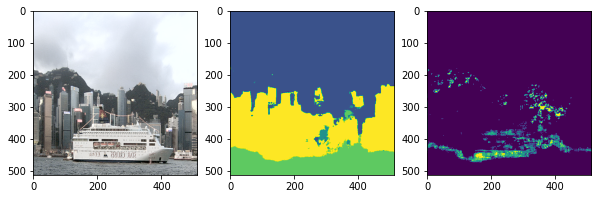

In [10]:
foo_x, [foo_y, foo_z] = next(iter(validation_ds.batch(1)))
y_pred, z_pred = evid_model(foo_x, training=False)
Skyline12.show_sample(foo_x[0], [y_pred[0], z_pred[0]], from_tensors=True)